In [1]:
import datetime
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from data import example_to_tensor
from train import EarlyStopping
from utils import plot_slice, plot_animated_volume

print(f"Tensorflow: {tf.__version__}")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Tensorflow: 2.3.0


In [171]:
verbose_training = True
# Hyperparameters
epochs = 1000
learning_rate = 0.0001
patience = 5
batch_size = 2
test_size = 2
validation_size = 2
xy_size = 128  # downscale 4
#z_size = 96  # downscale 4 (nrrd)
z_size = 248  # downscale 4 (tcia)
# xy_size = 256  # downscale 2
# z_size = 176  # downscale 2
# xy_size = 512   # original
# z_size = 368    # original

In [172]:
def normalize(t):
    "Normalize the input tensor in [0, 1]"
    max_value = tf.reduce_max(t)
    min_value = tf.reduce_min(t)
    return (t - min_value) / (max_value - min_value)

In [173]:
data_dir = Path("data/tcia-0.25")
tfrecord_fnames = [str(p) for p in data_dir.glob("*.tfrecord")]

dataset = tf.data.TFRecordDataset(tfrecord_fnames)
dataset = dataset.map(example_to_tensor)
dataset = dataset.map(normalize)
dataset = dataset.map(lambda x: tf.expand_dims(x, axis=-1))  # add the channel dimension
dataset = dataset.padded_batch(
    batch_size=2, 
    padded_shapes=[z_size, xy_size, xy_size, 1],
)
test_dataset = dataset.take(test_size)
dataset = dataset.skip(test_size)
val_dataset = dataset.take(validation_size)
train_dataset = dataset.skip(validation_size)
train_dataset = train_dataset.shuffle(buffer_size=64, reshuffle_each_iteration=True)
train_dataset

<ShuffleDataset shapes: (None, 248, 128, 128, 1), types: tf.float32>

In [174]:
encoder = keras.models.Sequential(
    [
        keras.layers.Conv3D(
            input_shape=[z_size, xy_size, xy_size, 1],
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
        keras.layers.Conv3D(
            filters=32,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
        keras.layers.Conv3D(
            filters=64,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
    ]
)
encoder.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_95 (Conv3D)           (None, 248, 128, 128, 16) 448       
_________________________________________________________________
activation_110 (Activation)  (None, 248, 128, 128, 16) 0         
_________________________________________________________________
alpha_dropout_95 (AlphaDropo (None, 248, 128, 128, 16) 0         
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 124, 64, 64, 16)   0         
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 124, 64, 64, 32)   13856     
_________________________________________________________________
activation_111 (Activation)  (None, 124, 64, 64, 32)   0         
_________________________________________________________________
alpha_dropout_96 (AlphaDropo (None, 124, 64, 64, 32) 

In [175]:
decoder = keras.models.Sequential(
    [
        keras.layers.UpSampling3D(
            input_shape=encoder.layers[-1].output.shape[1:], size=2,
        ),
        keras.layers.Conv3D(
            filters=64,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.UpSampling3D(size=2,),
        keras.layers.Conv3D(
            filters=32,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.UpSampling3D(size=2,),
        keras.layers.Conv3D(
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.Dense(1),
        keras.layers.Activation("sigmoid"),
    ]
)
decoder.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_43 (UpSampling (None, 62, 32, 32, 64)    0         
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 62, 32, 32, 64)    110656    
_________________________________________________________________
activation_113 (Activation)  (None, 62, 32, 32, 64)    0         
_________________________________________________________________
alpha_dropout_98 (AlphaDropo (None, 62, 32, 32, 64)    0         
_________________________________________________________________
up_sampling3d_44 (UpSampling (None, 124, 64, 64, 64)   0         
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 124, 64, 64, 32)   55328     
_________________________________________________________________
activation_114 (Activation)  (None, 124, 64, 64, 32) 

In [176]:
autoencoder = keras.models.Sequential([encoder, decoder])
# autoencoder.load_weights("models/autoencoder/20200723-103317/best_epoch_ckpt")
# autoencoder = keras.models.load_model("models/autoencoder/20200823-110737/")
autoencoder.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_46 (Sequential)   (None, 31, 16, 16, 64)    69664     
_________________________________________________________________
sequential_47 (Sequential)   (None, 248, 128, 128, 1)  179841    
Total params: 249,505
Trainable params: 249,505
Non-trainable params: 0
_________________________________________________________________


In [177]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(lr=learning_rate)

In [178]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/autoencoder/{current_time}/"
model_dir = f"models/autoencoder/{current_time}/"
ckpt_dir = model_dir + "best_epoch_ckpt"
writer = tf.summary.create_file_writer(log_dir)
early_stopping = EarlyStopping(patience)

for epoch in tqdm(range(epochs), disable=False):
    
    ### TRAIN ###
    
    train_loss_metric = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
    for batch in train_dataset:
        with tf.GradientTape() as tape:
            predictions = autoencoder(batch)
            loss_value = loss_fn(predictions, batch)
        gradients = tape.gradient(loss_value, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        train_loss_metric.update_state(loss_value)
        #with writer.as_default():
        #    for grad, param in zip(gradients, autoencoder.trainable_variables):
        #        tf.summary.histogram(param.name, param, step=epoch)
        #        # tf.summary.histogram(param.name + "/grad", grad, buckets=1, step=epoch)

    train_loss_mean = train_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Training loss", train_loss_mean, step=epoch)
    train_loss_metric.reset_states()
   
   ### VALIDATION ###

    val_loss_metric = tf.keras.metrics.Mean("val_loss", dtype=tf.float32)
    for batch in val_dataset:
        predictions = autoencoder(batch)
        val_loss_metric.update_state(loss_fn(predictions, batch))

    val_loss_mean = val_loss_metric.result()
    with writer.as_default():
        tf.summary.scalar("Validation loss", val_loss_mean, step=epoch)
    val_loss_metric.reset_states()

    if verbose_training:
        print()
        print(f"Epoch : {epoch}")
        print(f"Training loss: {train_loss_mean}")
        print(f"Validation loss: {val_loss_mean}")
    
    ### EARLY STOPPING ###
    
    early_stopping.update(val_loss_mean)
    if early_stopping.early_stop:
        autoencoder.load_weights(ckpt_dir)
        break
    elif early_stopping.not_improving_epochs == 0:
        autoencoder.save_weights(ckpt_dir)

autoencoder.save(model_dir)

with writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"batch size = {batch_size}; "
        f"patience = {patience}; "
        f"learning rate = {learning_rate}",
        step=0,
    )


Epoch : 0
Training loss: 0.002817259868606925
Validation loss: 0.0009087924263440073

Epoch : 1
Training loss: 0.0011549096088856459
Validation loss: 0.0006007178453728557

Epoch : 2
Training loss: 0.0007567880093120039
Validation loss: 0.0004777162102982402

Epoch : 3
Training loss: 0.0007236786186695099
Validation loss: 0.0004674546653404832

Epoch : 4
Training loss: 0.001034882036037743
Validation loss: 0.0003842680889647454

Epoch : 5
Training loss: 0.0005826816777698696
Validation loss: 0.00034572742879390717

Epoch : 6
Training loss: 0.0005363108939491212
Validation loss: 0.00030971402884460986

Epoch : 7
Training loss: 0.0005135552491992712
Validation loss: 0.0003021542215719819

Epoch : 8
Training loss: 0.0006409587804228067
Validation loss: 0.0002740526106208563

Epoch : 9
Training loss: 0.00046583227231167257
Validation loss: 0.00024877951364032924

Epoch : 10
Training loss: 0.0005290187546052039
Validation loss: 0.0004157280782237649

Epoch : 11
Training loss: 0.00043717995

In [196]:
%reload_ext tensorboard
%tensorboard --logdir=logs --bind_all

Reusing TensorBoard on port 6006 (pid 159635), started 5 days, 23:14:28 ago. (Use '!kill 159635' to kill it.)

In [197]:
original = next(iter(test_dataset.skip(1)))
encoder_out = autoencoder.layers[0](encoder_input)
decoder_out = autoencoder.layers[1](encoder_out)
batch_index = 0

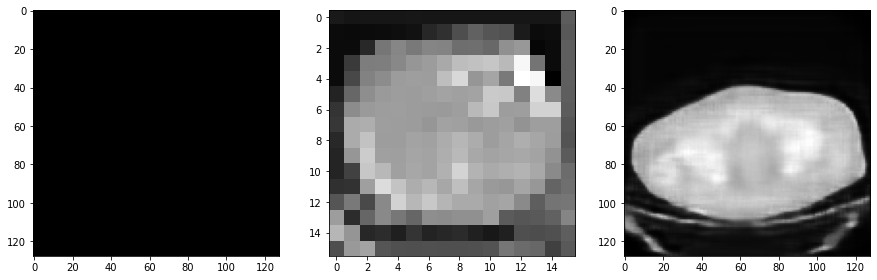

In [198]:
z_index = 20
fig, ax = plt.subplots(ncols=3)
plot_slice(original, batch_index, z_index, ax[0])
plot_slice(encoder_out, batch_index, encoder_out.shape[1] // 3, ax[1])
plot_slice(decoder_out, batch_index, z_index, ax[2])

In [199]:
plot_animated_volume(original, batch_index)

In [200]:
plot_animated_volume(encoder_out, batch_index, fps=10)

In [201]:
plot_animated_volume(decoder_out, batch_index)